In [1]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

In [4]:
data = pd.read_excel("Superstore.xls")

In [6]:
data.Category.unique()

array(['Furniture', 'Office Supplies', 'Technology'], dtype=object)

In [7]:
furniture = data.loc[data['Category'] == 'Furniture']

In [8]:
furniture['Order Date'].min(), furniture['Order Date'].max()


(Timestamp('2014-01-06 00:00:00'), Timestamp('2017-12-30 00:00:00'))

In [9]:
cols = furniture.columns

In [10]:
cols

Index(['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode',
       'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State',
       'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category',
       'Product Name', 'Sales', 'Quantity', 'Discount', 'Profit'],
      dtype='object')

In [11]:
colsOut = ['Row ID', 'Order ID', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State', 'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Quantity', 'Discount', 'Profit']
furniture.drop(colsOut, axis=1, inplace=True)
furniture = furniture.sort_values('Order Date')
furniture.isnull().sum()

Order Date    0
Sales         0
dtype: int64

In [12]:
furniture = furniture.groupby('Order Date')['Sales'].sum().reset_index()

In [13]:
#index by order date 
furniture = furniture.set_index('Order Date')

DatetimeIndex(['2014-01-06', '2014-01-07', '2014-01-10', '2014-01-11',
               '2014-01-13', '2014-01-14', '2014-01-16', '2014-01-19',
               '2014-01-20', '2014-01-21',
               ...
               '2017-12-18', '2017-12-19', '2017-12-21', '2017-12-22',
               '2017-12-23', '2017-12-24', '2017-12-25', '2017-12-28',
               '2017-12-29', '2017-12-30'],
              dtype='datetime64[ns]', name='Order Date', length=889, freq=None)

In [14]:
''' 
Our current datetime data can be tricky to work with, therefore, we will use the averages daily 
sales value for that month instead, and we are using the start of each month as the timestamp.
'''
y = furniture['Sales'].resample('MS').mean()

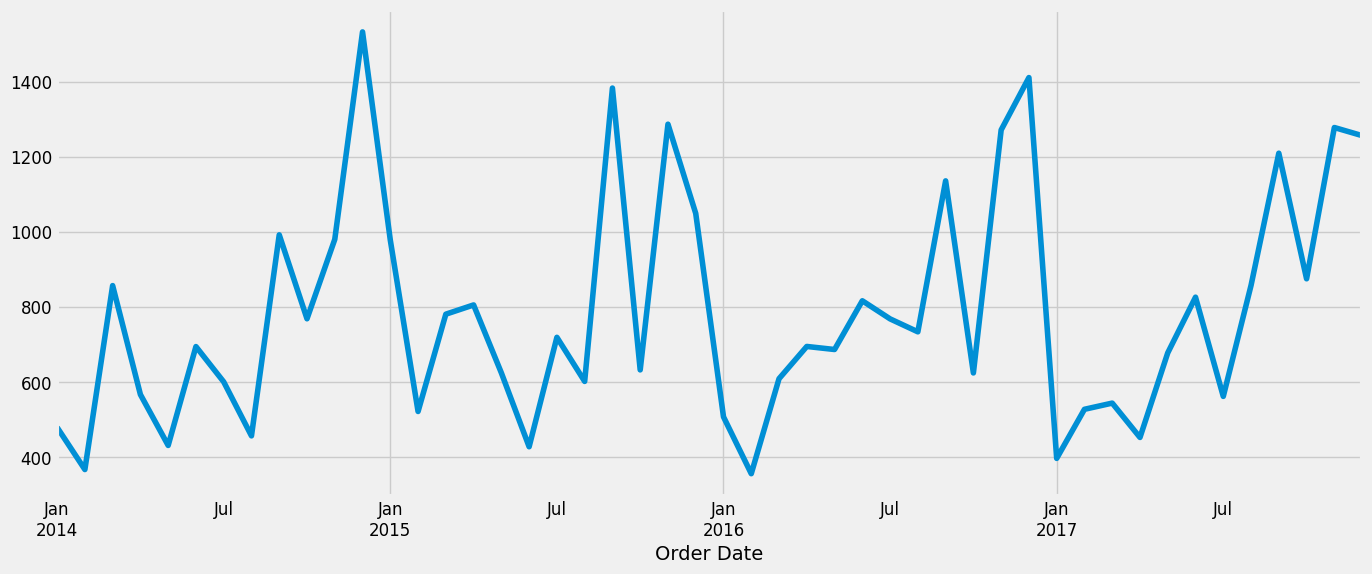

In [15]:
y.plot(figsize=(15, 6))
plt.show()

In [17]:
'''
The time-series has seasonality pattern, such as sales are always low at the beginning of the year and high
at the end of the year. There is always an upward trend within any single year with a couple of low months
in the mid of the year.
'''

'\nThe time-series has seasonality pattern, such as sales are always low at the beginning of the year and high\nat the end of the year. There is always an upward trend within any single year with a couple of low months\nin the mid of the year.\n'

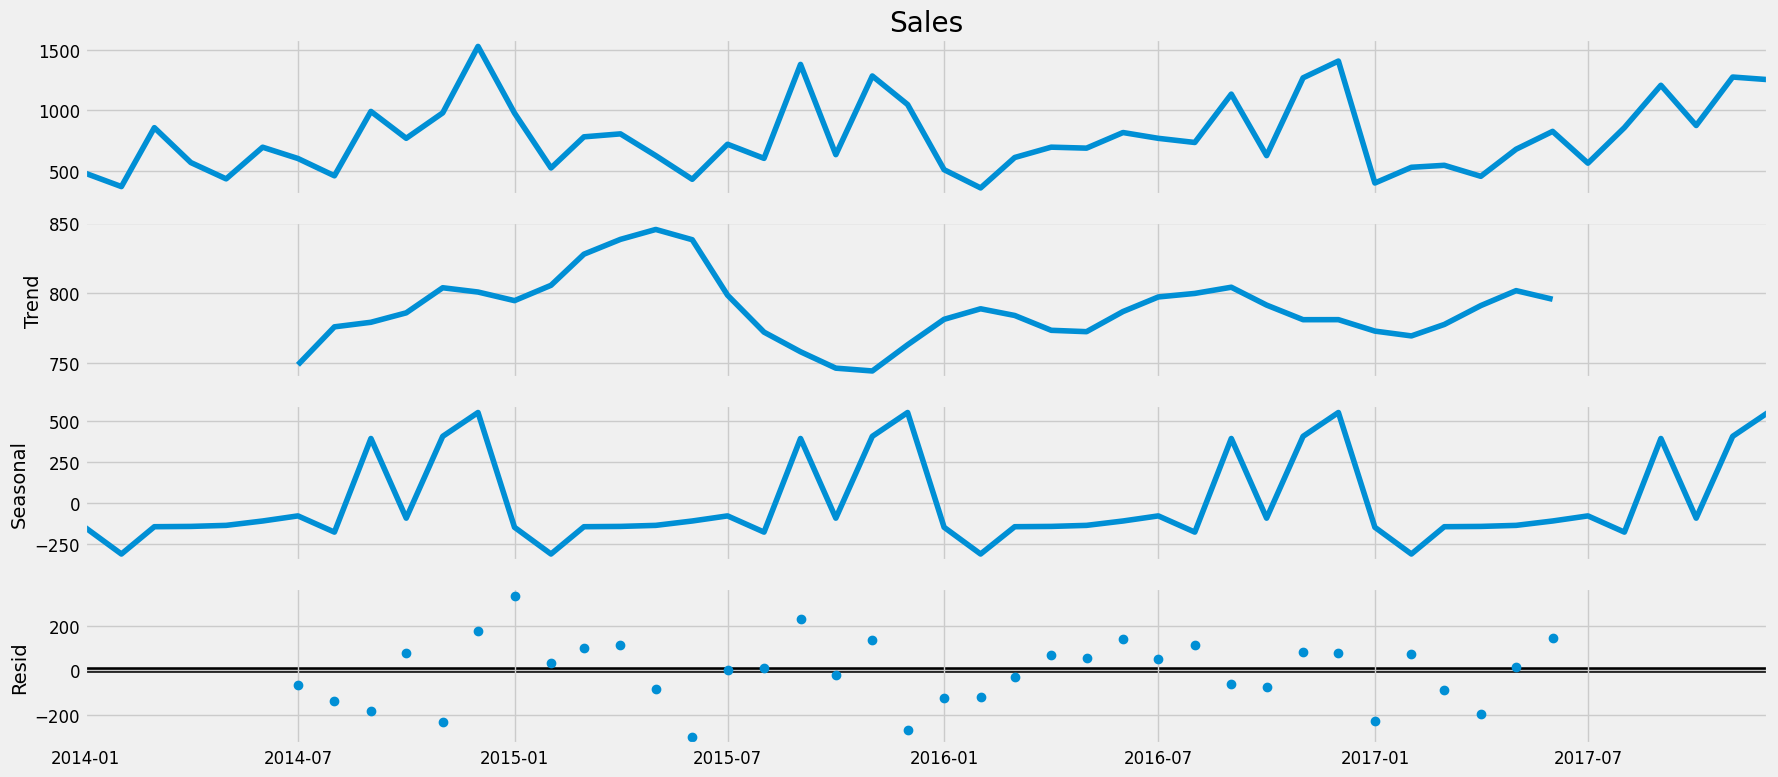

In [16]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

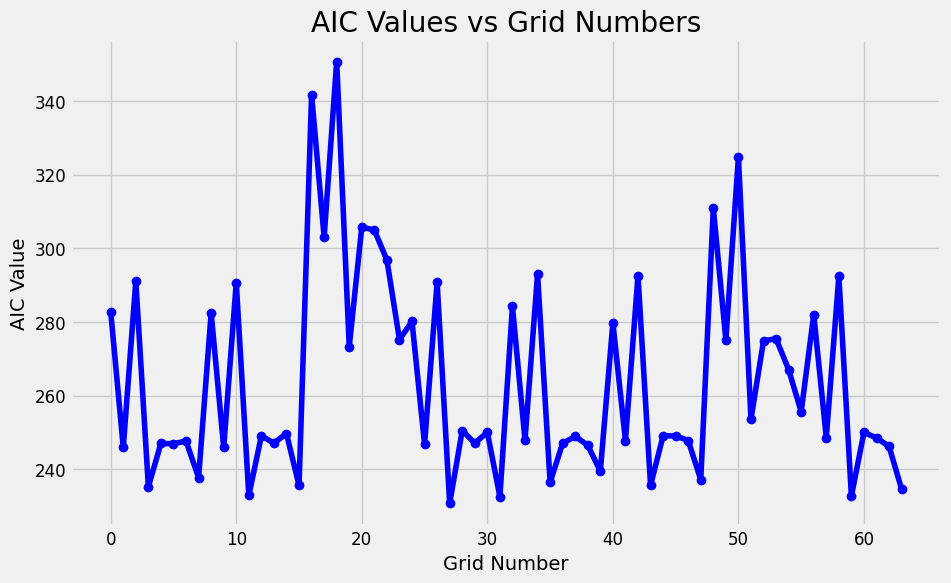

In [24]:
# Define ranges for SARIMA parameters
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in pdq]

# Initialize lists to store AIC values and corresponding grid numbers
aic_values = []
grid_numbers = []

# Simulated time series data
np.random.seed(0)
y = pd.Series(np.random.normal(size=100))

# Perform grid search over SARIMA parameters
for i, param in enumerate(pdq):
    for j, param_seasonal in enumerate(seasonal_pdq):
        try:
            mod = sm.tsa.statespace.SARIMAX(y, order=param, seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            aic_values.append(results.aic)
            grid_numbers.append((i, j))
        except:
            continue

# Plot AIC values against grid numbers
plt.figure(figsize=(10, 6))
plt.plot(range(len(aic_values)), aic_values, marker='o', linestyle='-', color='b')
plt.xlabel('Grid Number')
plt.ylabel('AIC Value')
plt.title('AIC Values vs Grid Numbers')
plt.show()

In [25]:
mod = sm.tsa.statespace.SARIMAX(y, order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0314      0.136     -0.231      0.817      -0.297       0.235
ma.L1         -0.9407      0.064    -14.684      0.000      -1.066      -0.815
ar.S.L12      -0.3612      0.120     -3.007      0.003      -0.597      -0.126
sigma2         1.4347      0.244      5.886      0.000       0.957       1.912


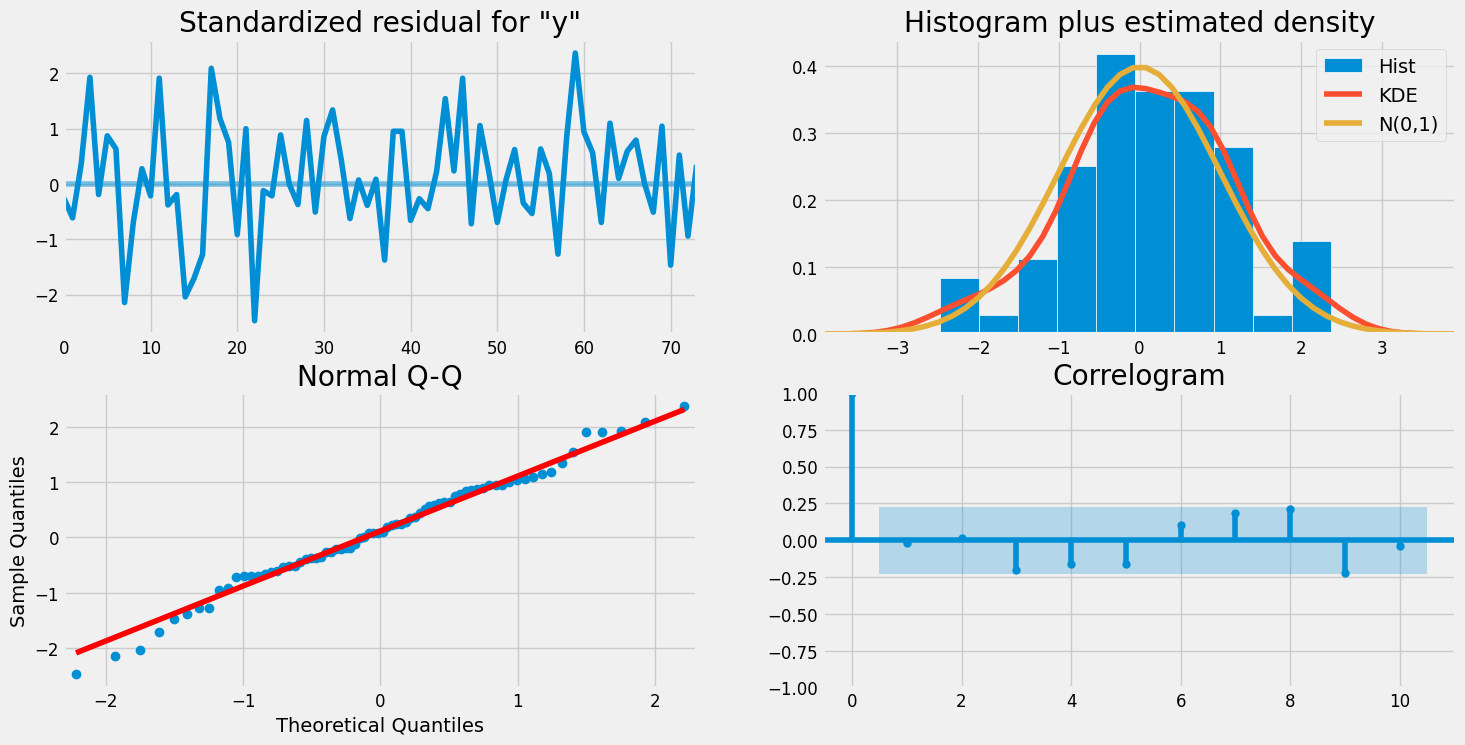

In [26]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

In [ ]:
# Assuming 'data' is your DataFrame with 'Date' as the datetime index
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Fit SARIMA model
mod = sm.tsa.statespace.SARIMAX(data["Views"], order=(p, d, q), seasonal_order=(P, D, Q, m),
                                enforce_stationarity=False, enforce_invertibility=False)
results = mod.fit()

# Perform prediction
pred = results.get_prediction(start=data.index[0], end=data.index[-1], dynamic=False)
pred_ci = pred.conf_int()

In [29]:
pred = results.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = y['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

KeyError: 'The `start` argument could not be matched to a location related to the index of the data.'

In [ ]:
y_forecasted = pred.predicted_mean
y_truth = y['2017-01-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

In [ ]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

In [ ]:
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()
ax = y.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

In [ ]:
furniture = df.loc[df['Category'] == 'Furniture']
office = df.loc[df['Category'] == 'Office Supplies']
furniture.shape, office.shape